# 理論部分
## pix2pixのやり方や課題 & CycleGANのモチベーション
- やりたいこと：mapping an image from one domain to another.
- Conditional GAN (CGAN)のlabelは別のdomainの画像にする。（下記の図を参考）
 - conditioning on a complete image.
 - 図のソース：[201611, Phillip Isola et al.]Image-to-Image Translation with Conditional Adversarial Networks. https://arxiv.org/abs/1611.07004
- そのためトレーニングするとき、pixelレベルの**paired data**が必要。
 - the exact same image, except in the other domain.
- CycleGANは**unpaired data**でimage-to-image translationをしたい。

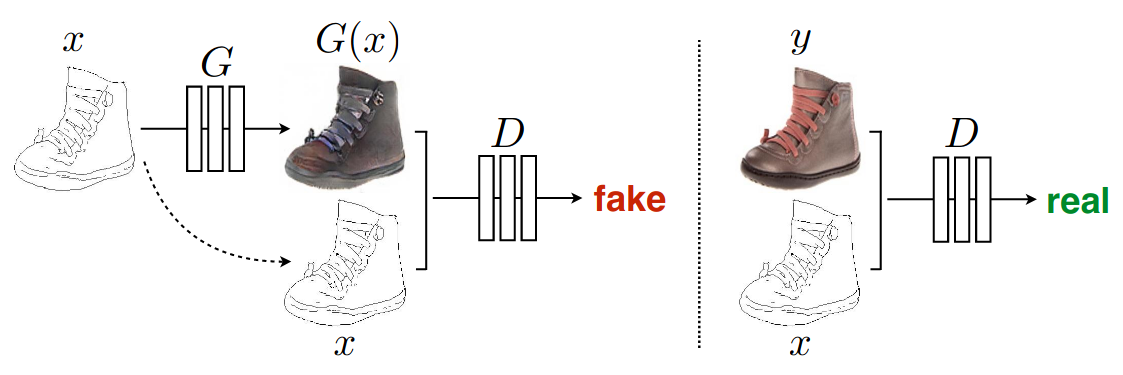

In [1]:
from IPython.display import Image
Image("img/pix2pix-2020-03-01 21-09-25.png")

## CycleGANのinsight（洞察）- G(x)の上にもう１つ逆方向Generatorを追加、xを再構成する
- 再構成した$\hat{x}$は、xとの差分でloss functionとして最適化できる。
- paired dataはいらなくなった。
- $\hat{x}$とxの差分は、CycleGAN上では**cycle-consistency loss**という。
- 例えばAとB２つdomainがあるので、２つ方向のGeneratorが必要。
 - $G_{AB}$: Domain A -> Domain B.
 - $G_{BA}$: Domain B -> Domain A.
- トレーニングするとき、２つcycleができるので、２つcycle-consistency lossを作れる。
 - MAE (mean absolute error) loss、L1 norm
 - Cycle-consistency loss 1: Domain A -> Domain B -> Domain A.
     - $\| \hat{a}-a \|_1$
 - Cycle-consistency loss 2: Domain B -> Domain A -> Domain B.
     - $\| \hat{b}-b \|_1$

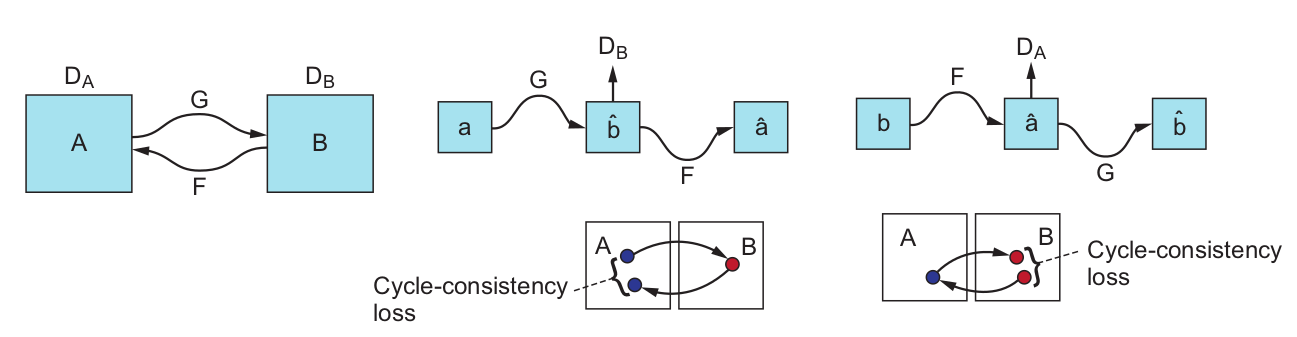

In [2]:
Image("img/cycle-consistency-loss-2020-03-01 22-52-33.png")

- cycle-consistency lossの考え方は明らかに**autoencoder**です。
- ただし、autoencoderは普段latent spaceはinput, outputよりだいぶ小さい。ここはlatent spaceのサイズはinput, outputと同じ。

## CycleGANの2つ目loss: adversarial loss
- このlossは通常のGANの考え方。
 - だからCycleGANはautoencoderとGANの混ぜ合わせるもの。
- 目標：
 - Generatorが生成した画像はなるべくrealになる。
 - DiscriminatorはなるべくGeneratorが生成した画像を拒否する。
- ２つDomainの画像があるので、２つDiscriminatorをトレーニングする。
 - Domain Aの画像に：$D_A$.
 - Domain Bの画像に：$D_B$.
- ２つトレーニングcycleがあるので、adversarial lossも２つ。
 - $D_A$のloss: $\mathbb{E}_{a\sim p_{data}(a)}log[D_A(a)]+\mathbb{E}_{b\sim p_{data}(b)}log[1-D_A(G_{BA}(b))]$
 - $D_B$のloss: $\mathbb{E}_{b\sim p_{data}(b)}log[D_B(b)]+\mathbb{E}_{a\sim p_{data}(a)}log[1-D_B(G_{AB}(a))]$
- CycleGANは$D_A$,$D_B$,$G_{AB}$,$G_{BA}$をトレーニングする。
- CycleGANのDiscriminatorの適用する対象は下の図を参考：
 - 注意すべきなのは、再構成した画像（Reconstructed）はDiscriminatorの適用対象ではないこと。
 - Reconstructed画像に対して適用してもいいけど、Translated画像に対するDiscriminatorのトレーニングはespecially important.
     - The first Discriminator in the cycle is especially important - otherwise, we'd simply get **noise that would help the GAN memorize what it should reconstruct**.

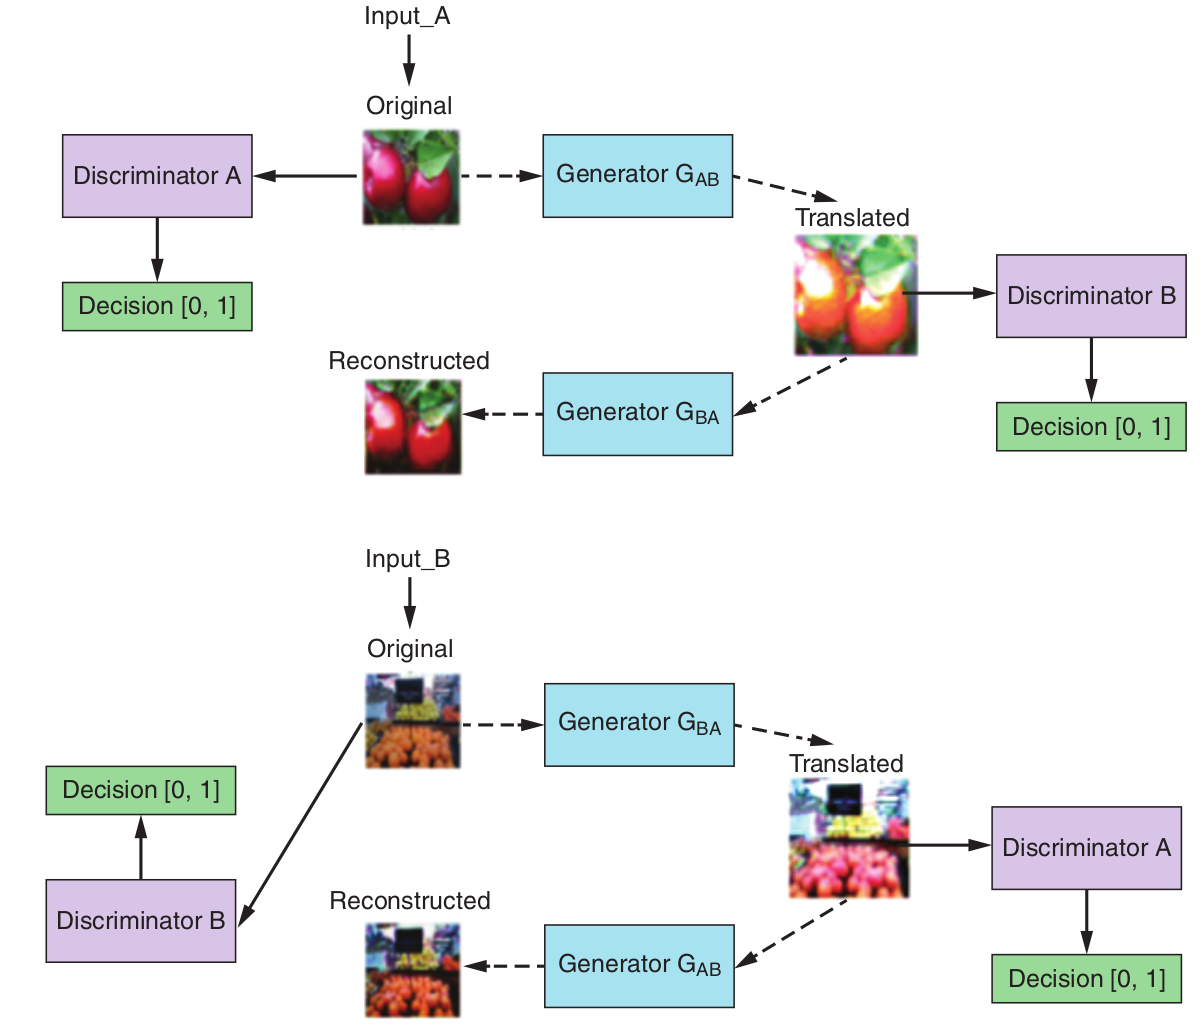

In [3]:
Image("img/cyclegan-discriminators-2020-03-01 23-55-58.png")

## CycleGANの3つ目loss function: Identity loss
- 必須ではない。
- 何をしている？identity lossの式からすぐ分かれる。
 - $\mathcal{L}_{identity}=E_{a\sim p(a)}[\|G_{BA}(a)-a\|_1]+E_{b\sim p(b)}[\|G_{AB}(b)-b\|_1]$
- Domain A -> Domain B変更する$G_{AB}$はDomain B（**target Domain**）の画像inputに対して、そのままの画像を出すべき。
 - The CycleGAN should **understand** that they are **already in the correct domain**.
- Identity lossあり、なしの差別は下記の図を参考。
 - source: [201703,Jun-Yan Zhu et al.] Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Network. https://arxiv.org/abs/1703.10593
 - identity lossの効果：keep the **tint**（色合い） of the picture consistent with the original image.

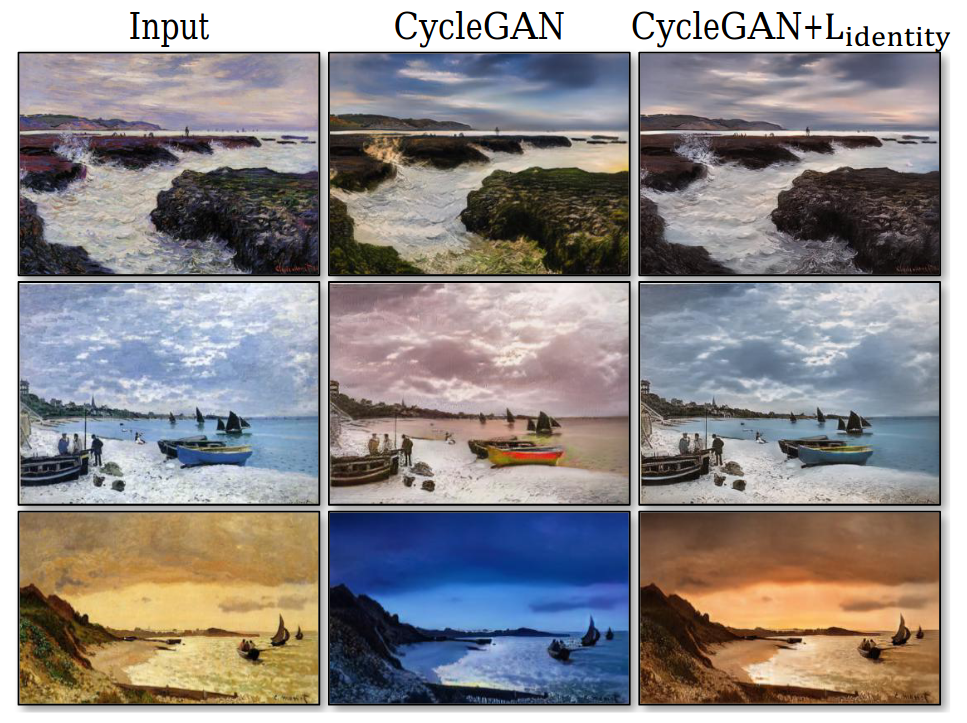

In [4]:
Image("img/cyclegan-identity-loss-2020-03-02 00-18-50.png")

## Generatorの構造
- CycleGAN Generatorは2種類のネットワーク構造がある。https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py
 - U-Net.
     - Autoencoder + Residual connection.
     - 下の図を参考。
     - U-Net architecture has just been empirically shown in several domains as better performing on various **segmentation tasks**.
 - Resnet-based generator.
     - Resnet-based generator consists of several Resnet blocks between a few downsampling/upsampling operations.

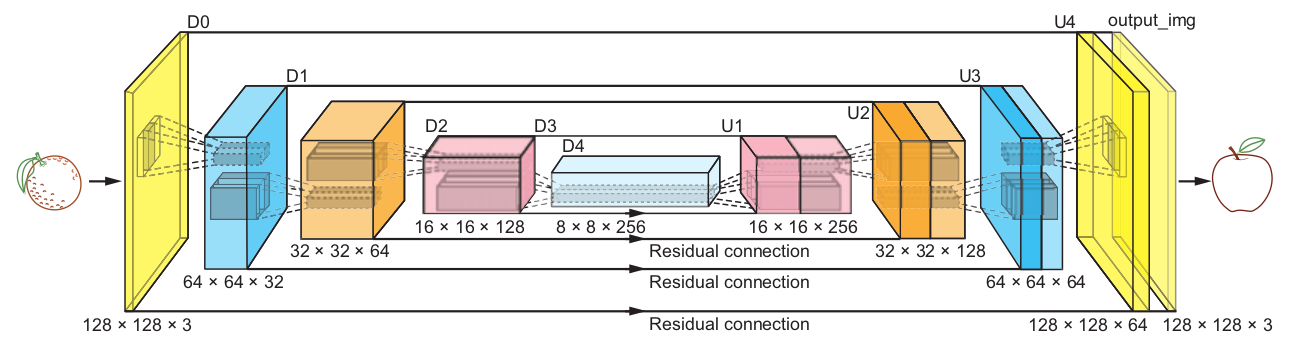

In [5]:
Image("img/u-net-generator-2020-03-02 00-48-55.png")

- 上記図の$D_0\rightarrow U_4$のresidual connectionはないはず。
- U-Netの形はまたautoencoderです。左半分はcontraction（収縮） path。右半分はexpanding path。
- residual connectionはskip connectionも言う。丸コピーだけです。
 - residual connectionで左downsamplingの層を右upsamplingの層に丸コピーするので、右側の層の**depthは2倍に**なっている。
 - The key idea is that although during downsampling we can focus on classification and understanding of large regions, including higher-resolution skip connections preserves the detail that can then be accurately **segmented**.
 - 僕の理解
     - skip connectionはもともとの画像の細かい輪郭をなるべく保持するためです。生成した画像は、入力画像と比べて、輪郭は変わらなくて、ただdomainが変わる。そういう意味だと、生成とはいえないでしょう。変換だけです。
     - 細かい輪郭は、segmentationに対して、意味が大きい。
     - Image-to-image translationはsegmentation taskとして理解していいかも。
     - autoencoder + skip connectionのようなやり方はsemantic segmentation taskのネットワークにも使われている。例えばSegNetに。
         - 下記の図のPooling Indicesを参考。論文は自動運転講座を受講した時知った。[201511,Vijay Badrinarayanan et al.]SegNet: A Deep Convolutional Encoder-Decoder Architecture for Image Segmentation. https://arxiv.org/pdf/1511.00561.pdf
- ToDo:
 - ResNetを理解する。
 - なぜGeneratorがResNetやU-Netを使うかを理論的に理解する。

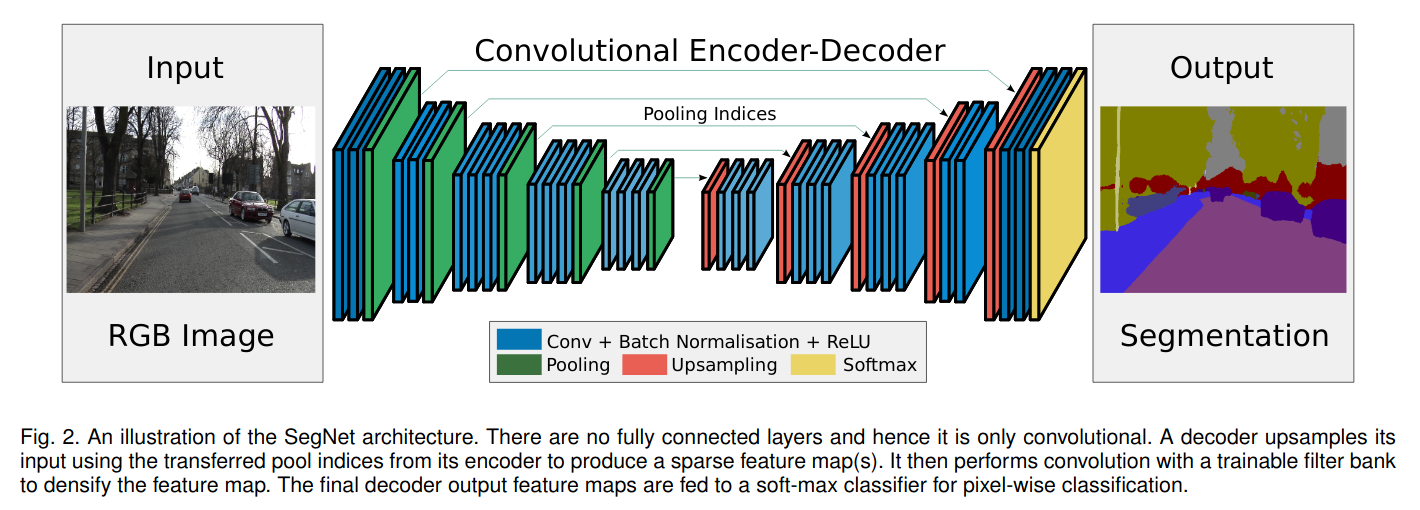

In [6]:
Image("img/seg-net-2020-03-02 13-05-54.png")

## Discriminatorの構造
- CycleGAN発明者Jun-Yan Zhuは3種類Discriminatorの実現を提供している。https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py
 - [basic]: 'PatchGAN' classifierを使う。
     - 名前の通り、画像全体ではなく、70x70のpatchに対して、realかfakeかを判定する。実際のpatchのサイズは変わるかも。
         - なので、画像に対して、Dの出力はscalarではなく、画像サイズ/patchサイズ個realかの確率だ。
     - described in the original pix2pix paper.
     - Such a **patch-level discriminator** architecture has **fewer parameters than a full-image discriminator** and can work on arbitrarily-sized images in a fully convolutional fashion.
 - [n\_layers]: Conv層の数を指定できるモード。3だったらPatchGANになる。
 - [pixel]: 1x1 PixelGAN discriminator can classify whether a pixel is real or not.
     - It encourages greater color diversity but has no effect on spatial statistics.
     - no effect on spatial statisticsはもちろん、pixelごとに判定しているから。pixelと近くのpixelsの関係は見ない。

## CycleGANの正規化：Instance Normalization
- Batch Normalizationは今回の例に使っていない。Jun-Yan Zhuのコードにはbatch, instance正規化両方提供している。
- 例えばtensorのサイズが[B,W,H,C]。（batch_size, width, height, number_of_channels）
 - Instance Normalizationはwidth, heightに対して正規化する。（つまりfeature mapに対して正規化する）
 - Batch Normalizationはbatch_sizeに対して正規化する。
- channel軸に対して正規化するのはある？
 - ある。実はProgressive GANの中に大切な正規化はchannel軸に対する正規化です。
 - **pixel-wise feature normalization**という。
     - $b_{x,y}=a_{x,y}/\sqrt{\frac{1}{N}\sum_{j=0}^{N-1}(a_{x,y}^j)^2+\epsilon}$
     - $N$はfeature mapの数。つまりchannelの数。つまりdepth。

# 実装部分

## Step 1: keras-contribインストールやapple2orangeデータセットダウンロード
- keras-contribのInstanceNormalizationを使うため
- IPython notebook内commandやbash実施。
- terminalでやった方がいいでしょう。

In [7]:
!pip install git+https://github.com/keras-team/keras-contrib.git

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-icqm8qd0
  Running command git clone -q https://github.com/keras-team/keras-contrib.git /tmp/pip-req-build-icqm8qd0
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101241 sha256=82e2b784f1d4c61de2da2207386f6436942afe54c5d92017793853308cc5c09d
  Stored in directory: /tmp/pip-ephem-wheel-cache-er7__xk7/wheels/f5/ab/81/80c7035f13b497bcc8b81206ef9f46242e78f3bdedaea5c1ec
Successfully built keras-contrib


- 下のbashはこのnotebookのhome directoryにapple2orangeフォルダー（中に解凍された画像）を作るので、ほかのフォルダーに解凍したければ、unzipに-dで指定してください。
- apple2orangeフォルダーの構造は下記です。Domain Aはりんご。Domain Bはみかん。
 - testA
 - testB
 - trainA
 - trainB

In [ ]:
%%bash
FILE=apple2orange
ZIP_FILE=./$FILE.zip
URL=https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/$FILE.zip
wget -N $URL -O $ZIP_FILE
unzip $ZIP_FILE
rm $ZIP_FILE

## Step 2: DataLoaderクラスを用意
- load_data関数：load data from disk based on the dataset name, which we will define in CyCleGAN's \_\_init__
- load_batch関数：トレーニング中batchを用意する。
 - 一回shuffleして、大きさbatch_sizeの(imgs_A, imgs_B)をどんどん出す。データセットが終わるまで。これは１つepochです。
 - defined as a **generator for greater efficiency**.
 - つまりreturnではなく、for loopの中にdatasetを遍歴しながら、**yield**でbatchを１つずつ出す。 

In [ ]:
import scipy
from glob import glob
import numpy as np

class DataLoader():
    def __init__(self, dataset_name, img_res=(128, 128)):
        self.dataset_name = dataset_name
        self.img_res = img_res
    
    def load_data(self, domain, batch_size=1, is_testing=False):
        # testA, testB, trainA, trainBのどれから全ての画像のパスを取る
        data_type = "train%s" % domain if not is_testing else "test%s" % domain
        path = glob('./%s/%s/*' % (self.dataset_name, data_type))
        
        # batch_size枚画像のパスを選ぶ
        batch_images = np.random.choice(path, size=batch_size)
        
        

- numpy.random.choice(a,size,replace,p):Generates a random sample from a given 1-D array.
 - If a is an ndarray, a random sample is generated from its elements.上記のpathの場合。
 - If a is an int, the random sample is generated as if a were np.arange(a).
 - size is output shape. If the given shape is (m, n, k), then m * n * k samples are drawn.